In [0]:
%matplotlib inline

# Multi layer perceptron from scratch - CIFAR10 dataset

A neural network needs a few building blocks

- Dense layer - a fully-connected layer, $f(X)=W \cdot X + \vec{b}$
- Activation function to introduce non-linearity: ReLU layer, Leaky_ReLU, TanH (Hyperbolic tangent function), Sigmoid are some examples of activation functions
- Loss function (crossentropy in case of multi-class classification problem)
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Let's approach them one at a time.

Let's start by importing some libraires required for creating our neural network.

In [0]:
from __future__ import print_function
import numpy as np ## For numerical python
np.random.seed(42)

Every layer will have a forward pass and backpass implementation. Let's create a main class layer which can do a forward pass .forward() and Backward pass .backward().

In [0]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here we can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If our layer has parameters (e.g. dense layer), we also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

### Nonlinearity ReLU layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of your network.

In [0]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad

### Nonlinearity Leaky ReLU layer

Leaky ReLUs allow a small, positive gradient when the unit is not active.

In [0]:
class LeakyReLU(Layer):
    def __init__(self):
        """Leaky ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise Leaky ReLU to [batch, input_units] matrix"""
        relu_forward = np.where(input > 0, input, input * 0.01)
        return relu_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. Leaky ReLU input"""
        relu_grad = np.where(input > 0, 1.0, 0.01)
        return grad_output*relu_grad

### Nonlinearity TanH

The Hyperbolic Tangent function is almost linear near the origin, but quickly saturates at -1,1 when the input moves away from the origin.

In [0]:
class TanH(Layer):
    def __init__(self):
        """Hyperbolic tangent layer"""
        pass
    
    def forward(self, input):
        """Apply elementwise Hyperbolic Tangent to [batch, input_units] matrix"""
        tanh_forward = np.tanh(input)
        return tanh_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. Hyperbolic Tangent input"""
        tanh_grad = 1.0-np.tanh(input)*np.tanh(input)
        return grad_output*tanh_grad

### Nonlinearity Sigmoid

The Logistic Sigmoid function varies smoothly from 0 to 1.

In [0]:
class Sigmoid(Layer):
    def __init__(self):
        """Sigmoid layer"""
        pass

    def sigmoid(self, x):
        return 1/(1 + np.exp(-x)) 

    def forward(self, input):
        """Apply elementwise Sigmoid function to [batch, input_units] matrix"""
        sigmoid_forward = self.sigmoid(input)
        return sigmoid_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. Sigmoid input"""
        sigmoid_grad = self.sigmoid(input)*(1.0-self.sigmoid(input))
        return grad_output*sigmoid_grad

Let's store the nonlinearity functions in an enumeration to make the code more clear.



In [0]:
from enum import Enum, unique

@unique
class ActivationFunction(Enum):
    RELU = 1
    LEAKY_RELU = 2
    TANH = 3 # Hyperbolic tangent function
    SIGMOID = 4


def get_activation_function(activation):
    if activation == ActivationFunction.RELU:
        return ReLU()
    elif activation == ActivationFunction.LEAKY_RELU:
        return LeakyReLU()
    elif activation == ActivationFunction.TANH:
        return TanH()
    elif activation == ActivationFunction.SIGMOID:
        return Sigmoid()

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= W \cdot X + \vec b $$

Where 
* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs] 
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called. Note that we are using **Xavier initialization** which is a trick to train our model to converge faster [read more](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization). Instead of initializing our weights with small numbers which are distributed randomly we initialize our weights with mean zero and variance of 2/(number of inputs + number of outputs)

In [0]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input,self.weights) + self.biases
    
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If we write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If we take a closer look, we'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

In [0]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

### Full network

Now let's combine what we've just built into a working neural network. We are going to use CIFAR-10 dataset of labeled images for our example. Fortunately, Keras already have it in the numpy array format, so let's import it!.

Example training images and their labels: [6, 9, 9, 4, 1]
Corresponding classes for the labels: ['frog', 'truck', 'truck', 'deer', 'automobile']


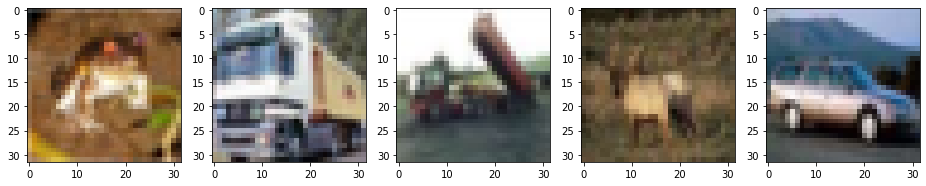

In [74]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(X_train, y_train):
    cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    print('Example training images and their labels: ' + str([x[0] for x in y_train[0:5]])) 
    print('Corresponding classes for the labels: ' + str([cifar_classes[x[0]] for x in y_train[0:5]]))

    f, axarr = plt.subplots(1, 5)
    f.set_size_inches(16, 6)

    for i in range(5):
        img = X_train[i]
        axarr[i].imshow(img)
    plt.show()


def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

    show_images(X_train, y_train)

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_dataset(flatten=True)

We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [0]:
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

In [0]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    """
    activations = []
    input = X

    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions. Returning indices of largest Logit probability
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    """
    Train our network on a given batch of X and y.
    We first need to run forward to get all layer activations.
    Then we can run layer.backward going from last to first layer.
    After we have called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)

### Training loop

We split data into minibatches, feed each such minibatch into the network and update weights. This training method is called a mini-batch stochastic gradient descent.

In [0]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [0]:
def get_network(input_units, output_units, learning_rate=0.1, epochs=25, dense_output_units=[100, 200], activation_function=ActivationFunction.RELU, print_network=False):
    if print_network:
        print('\tNETWORK: Multi layer perceptron')
    network = []
    network.append(Dense(input_units, dense_output_units[0], learning_rate))
    if print_network:
        print('\t\tDense(input_units={}, output_units={}, learning_rate={})'.format(input_units, dense_output_units[0], learning_rate))
    network.append(get_activation_function(activation_function))
    if print_network:
        print('\t\t{}()'.format(activation_function.name))
    
    for i, _ in enumerate(dense_output_units):
      if i == len(dense_output_units) - 1:
        break
      network.append(Dense(dense_output_units[i], dense_output_units[i+1], learning_rate))
      if print_network:
          print('\t\tDense(input_units={}, output_units={}, learning_rate={})'.format(dense_output_units[i], dense_output_units[i+1], learning_rate))
      network.append(get_activation_function(activation_function))
      if print_network:
          print('\t\t{}()'.format(activation_function.name))
    
    network.append(Dense(dense_output_units[-1], output_units))
    if print_network:
        print('\t\tDense(input_units={}, output_units={}, learning_rate={})'.format(dense_output_units[-1], output_units, learning_rate))

    return network

In [0]:
from IPython.display import clear_output
from time import time

def training_loop(network, input_units, output_units, learning_rate=0.1, epochs=25, dense_output_units=[100, 200], batchsize=32, shuffle=True):
    if len(dense_output_units) < 2:
      return

    epoch_start = time()
    train_acc_list = []
    test_acc_list = []
    epoch_time_list = []

    for epoch in range(epochs):

        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=batchsize,shuffle=shuffle):
            train(network,x_batch,y_batch)
        
        train_acc_list.append(np.mean(predict(network,X_train)==y_train))
        test_acc_list.append(np.mean(predict(network,X_test)==y_test))
        
        clear_output()
        print("Epoch", epoch)
        print("Training accuracy: {:.2f}%".format(train_acc_list[-1]*100))
        print("Test accuracy: {:.2f}%".format(test_acc_list[-1]*100))
        epoch_time = time() - epoch_start
        epoch_time_list.append(epoch_time)
        print("Epoch's processing time: {:.2f} seconds".format(epoch_time))
        plt.plot(train_acc_list, label='train accuracy')
        plt.plot(test_acc_list, label='test accuracy')
        plt.legend(loc='best')
        plt.grid()
        plt.show()
    
    return train_acc_list, test_acc_list, epoch_time_list

## Testing different dense layers

* Using **2 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using **3 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using **4 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using **5 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [0]:
test_accuracy_list = []

In [0]:
from time import time
import numpy as np

def mlp_training(network, input_units, output_units, learning_rate, epochs, dense_output_units, batchsize, shuffle):
    training_start = time()
    train_acc_list, test_acc_list, epoch_time_list = training_loop(network, input_units=input_units, output_units=output_units, learning_rate=learning_rate, epochs=epochs, dense_output_units=dense_output_units, batchsize=batchsize, shuffle=shuffle)
    print("Total time: {} seconds".format(time() - training_start))

    labels = ['epoch {}'.format(str(i).zfill(3)) for i in range(epochs)]

    train_acc_np = np.asarray(train_acc_list)
    print("\nTraining accuracy list: {}".format(train_acc_np))
    print("Training accuracy (Mean +/- Std): %0.2f (+/- %0.2f)" % (train_acc_np.mean()*100, train_acc_np.std() * 2))
    # Plot horizontal bar
    values = [v * 100 for v in train_acc_list]
    plot_horizontal_bar(labels, values, xlabel='Accuracy', ylabel='', title='Training accuracy per epoch', use_xlim=True)

    test_acc_np = np.asarray(test_acc_list)
    print("\nTest accuracy list: {}".format(test_acc_np))
    print("Test accuracy (Mean +/- Std): %0.2f (+/- %0.2f)" % (test_acc_np.mean()*100, test_acc_np.std() * 2))

    # Save test accuracy to plotting: Test accuracy Vs Number of dense layers
    test_accuracy_list.append(test_acc_np.mean()*100)

    # Plot horizontal bar
    values = [v * 100 for v in test_acc_list]
    plot_horizontal_bar(labels, values, xlabel='Accuracy', ylabel='', title='Test accuracy per epoch', use_xlim=True)

    epoch_time_np = np.asarray(epoch_time_list)
    print("\nEpoch time list: {}".format(epoch_time_np))
    print("Epoch time (Mean +/- Std): %0.2f (+/- %0.2f)" % (epoch_time_np.mean(), epoch_time_np.std() * 2))
    # Plot horizontal bar
    values = [v * 100 for v in epoch_time_list]
    plot_horizontal_bar(labels, values, xlabel='Time', ylabel='', title='Epoch time in seconds', use_xlim=False)

In [0]:
def plot_horizontal_bar(x, y, xlabel, ylabel, title, use_xlim=False):
    fig, ax = plt.subplots()    
    width = 0.75 # the width of the bars 
    ind = np.arange(len(y))  # the x locations for the groups
    ax.barh(ind, y, width, color="blue")
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(x, minor=False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    for i, v in enumerate(y):
        ax.text(v + 3, i + .25, '%0.2f'%(v), color='blue', fontweight='bold')
    
    if use_xlim:
        plt.xlim(0, 120)
        plt.tight_layout()
    
    plt.show()

Define the activation function used. Using RELU.

Options:
* ActivationFunction.RELU
* ActivationFunction.LEAKY_RELU
* ActivationFunction.TANH
* ActivationFunction.SIGMOID

In [0]:
activation_function = ActivationFunction.RELU

Define number of epochs

In [0]:
epochs=25

### Using **2 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [22]:
dense_output_units=[100, 200]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=epochs, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=3072, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 525.70 seconds


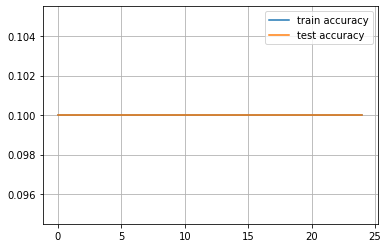

Total time: 525.8590557575226 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


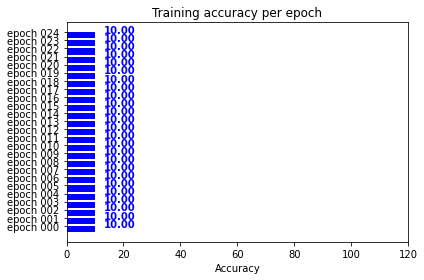


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


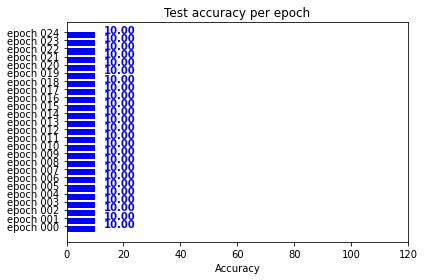


Epoch time list: [ 22.39945006  42.65789151  63.22569442  83.73166084 104.35581326
 124.85575795 145.72672272 166.59476781 187.07915974 207.39337683
 227.75864625 248.04174161 268.39130139 288.88814926 310.13502622
 331.59625626 352.97423387 374.18675447 395.93284297 418.97895384
 439.67483282 460.80140471 482.71675563 504.19986367 525.69765878]
Epoch time (Mean +/- Std): 271.12 (+/- 302.08)


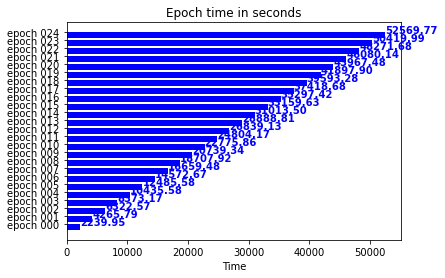

In [23]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using **3 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [24]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=epochs, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=3072, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 607.88 seconds


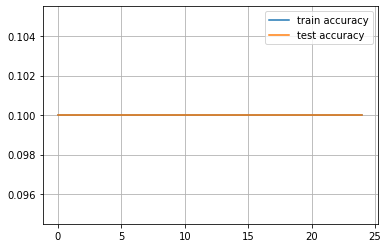

Total time: 608.0300176143646 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


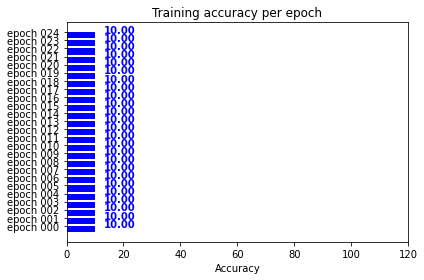


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


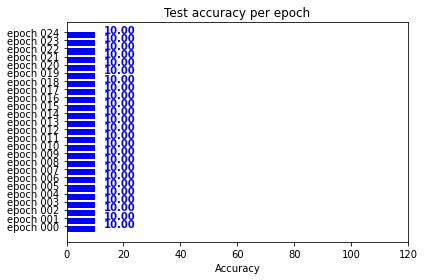


Epoch time list: [ 23.79422641  47.05863762  71.84465837  96.54704332 119.4396894
 142.58997059 166.76765895 192.12686634 216.72076917 241.45025802
 265.8486197  290.50584769 314.73934722 339.13740301 363.53320718
 387.9811995  411.7301209  436.02970481 460.61144209 486.77083421
 510.80156589 535.18532252 559.88372135 583.79325294 607.87601995]
Epoch time (Mean +/- Std): 314.91 (+/- 351.99)


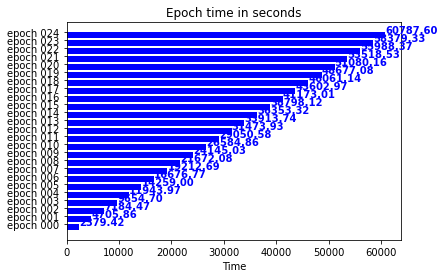

In [25]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using **4 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [26]:
dense_output_units=[100, 200, 300, 400]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=epochs, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=3072, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=400, learning_rate=0.1)
		RELU()
		Dense(input_units=400, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 728.35 seconds


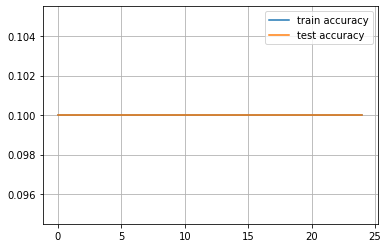

Total time: 728.5094330310822 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


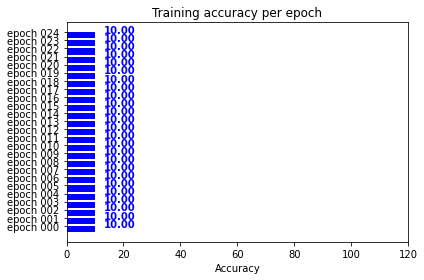


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


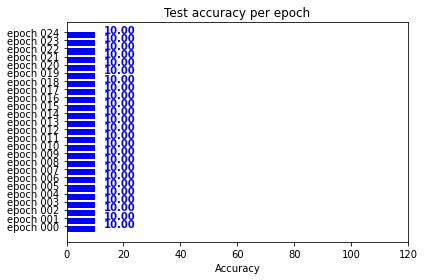


Epoch time list: [ 29.27183795  58.55963182  87.59412003 116.83772779 146.2745657
 175.54392743 204.87614322 234.26630569 263.63179517 293.15189457
 322.66269994 352.08239222 381.50271964 410.48176646 439.34162116
 468.90861225 500.72307587 530.43223786 559.58106327 588.101511
 616.7721622  644.83732772 673.05164123 700.79096651 728.35157871]
Epoch time (Mean +/- Std): 381.11 (+/- 422.56)


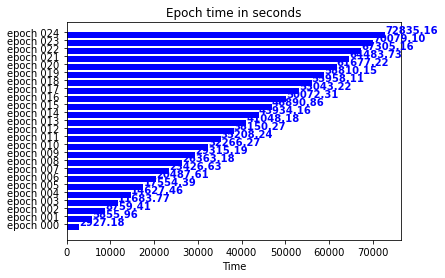

In [27]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using **5 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [28]:
dense_output_units=[100, 200, 300, 400, 500]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=epochs, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=3072, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=400, learning_rate=0.1)
		RELU()
		Dense(input_units=400, output_units=500, learning_rate=0.1)
		RELU()
		Dense(input_units=500, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 899.22 seconds


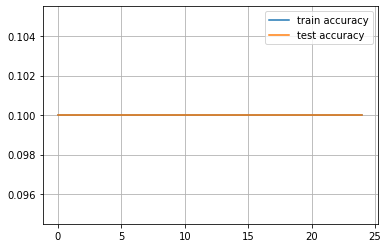

Total time: 899.3738775253296 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


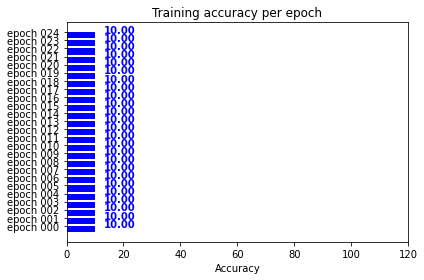


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


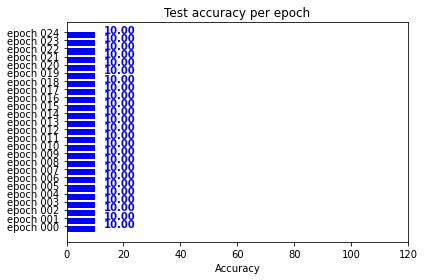


Epoch time list: [ 34.74730968  70.04481244 105.28682184 140.71840405 175.67785501
 211.92783856 248.72595525 284.01690888 319.57337952 356.22191358
 394.7094171  431.41516137 467.46591783 504.27503681 541.28343248
 578.2525661  615.30454397 651.10122132 687.39442468 722.95690989
 758.39592338 793.80715013 829.13318539 864.18102312 899.22347021]
Epoch time (Mean +/- Std): 467.43 (+/- 523.06)


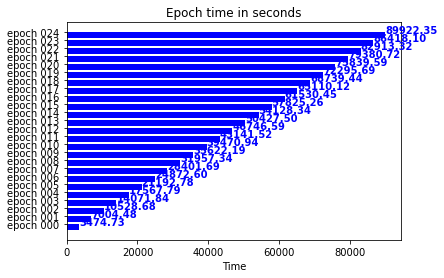

In [29]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

## Best number of dense layers

* Highest test accuracy (mean)

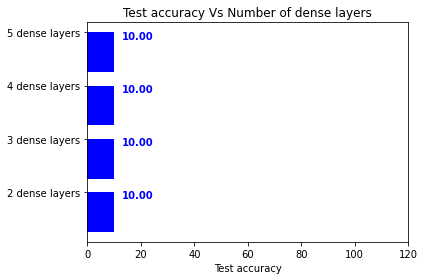

In [30]:
labels = ['2 dense layers', '3 dense layers', '4 dense layers', '5 dense layers']
plot_horizontal_bar(labels, test_accuracy_list, xlabel='Test accuracy', ylabel='', title='Test accuracy Vs Number of dense layers', use_xlim=True)

In [0]:
test_accuracy_list = []

## Testing different learning rates

* Using 3 dense layers with **learning_rate=0.1**, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using 3 dense layers with **learning_rate=0.01**, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using 3 dense layers with **learning_rate=0.001**, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using 3 dense layers with **learning_rate=0.0001**, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [32]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=epochs, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=3072, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


### Using 3 dense layers with **learning_rate=0.1**, activation function = RELU, minibatches with batchsize=32, shuffle=True

Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 604.84 seconds


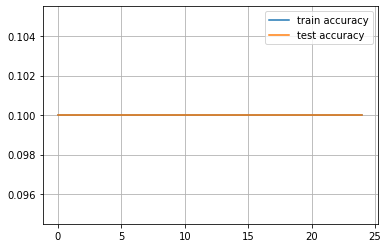

Total time: 604.9926955699921 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


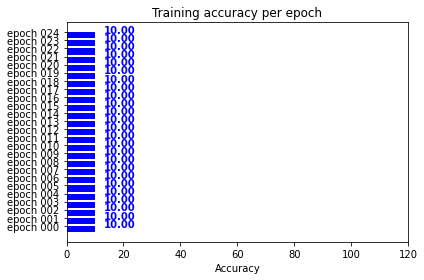


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


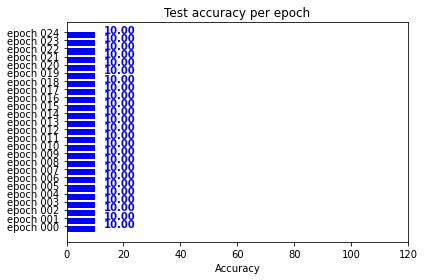


Epoch time list: [ 23.08409381  46.44581556  70.56319642  95.29124331 118.794981
 142.24374914 165.59673142 190.00505424 214.20676327 238.44706893
 262.93686032 287.48215842 311.37718248 336.23015213 361.14700174
 385.98972154 410.72183466 435.72484732 460.11559892 483.93510604
 508.11003208 531.95695353 556.17903948 580.71364284 604.84374499]
Epoch time (Mean +/- Std): 312.89 (+/- 350.80)


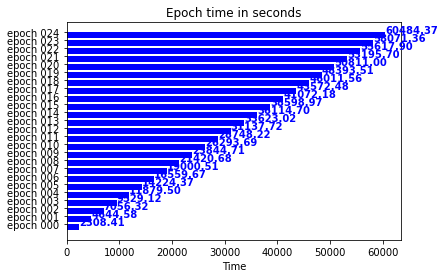

In [33]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with **learning_rate=0.01**, activation function = RELU, minibatches with batchsize=32, shuffle=True

Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 594.15 seconds


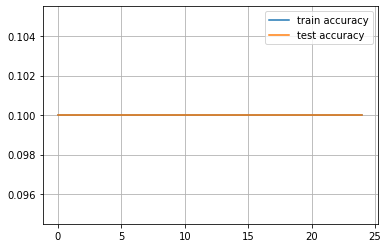

Total time: 594.3043410778046 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


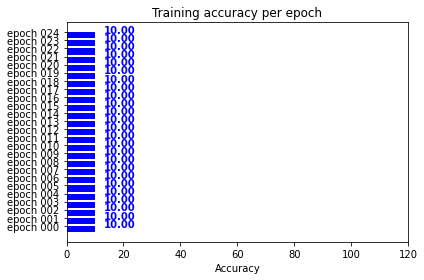


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


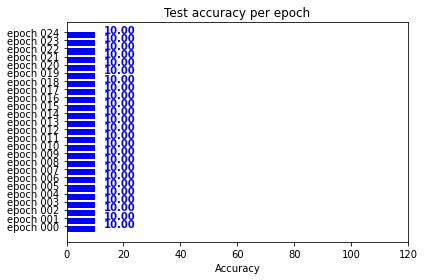


Epoch time list: [ 23.63166404  47.1504364   70.71719265  96.58766341 120.1711719
 144.37099695 168.18748188 191.8881166  215.51691842 239.3112092
 262.86385202 286.29717326 309.94992352 333.48130608 357.10462499
 381.33621097 405.12845707 428.71229982 452.40285897 476.46917081
 500.19865489 523.58764791 547.10617518 570.65215588 594.15353727]
Epoch time (Mean +/- Std): 309.88 (+/- 342.65)


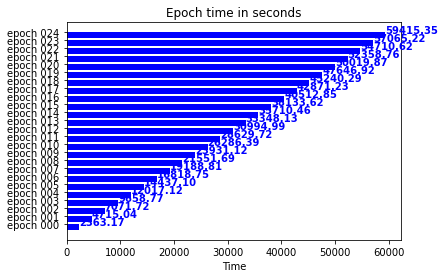

In [34]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.01, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with **learning_rate=0.001**, activation function = RELU, minibatches with batchsize=32, shuffle=True

Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 595.49 seconds


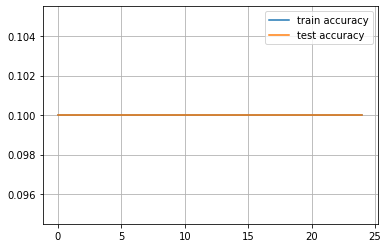

Total time: 595.6485269069672 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


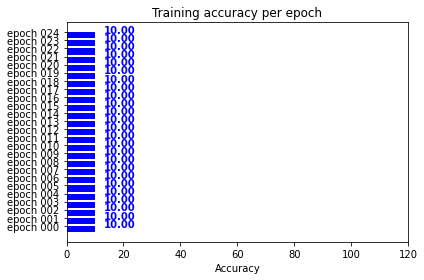


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


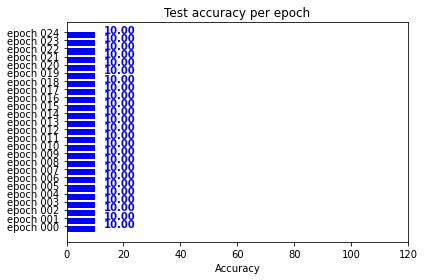


Epoch time list: [ 23.61545134  47.11988044  70.63175321  95.45720553 118.81416297
 142.62627077 166.30042458 189.93787932 213.69295025 237.52420044
 261.13651824 285.0619483  308.8334403  332.65967274 356.47723675
 380.63659072 404.43905783 428.69914675 452.44940019 476.23617363
 500.35900354 524.2103126  547.94491482 571.87060618 595.49150157]
Epoch time (Mean +/- Std): 309.29 (+/- 343.87)


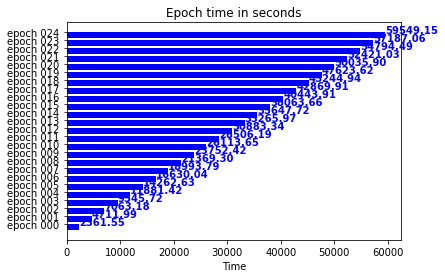

In [35]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with **learning_rate=0.0001**, activation function = RELU, minibatches with batchsize=32, shuffle=True

Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 604.88 seconds


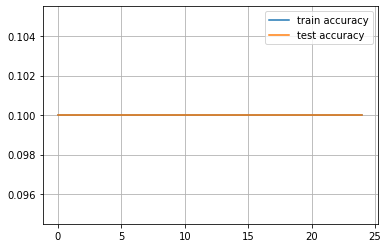

Total time: 605.2029719352722 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


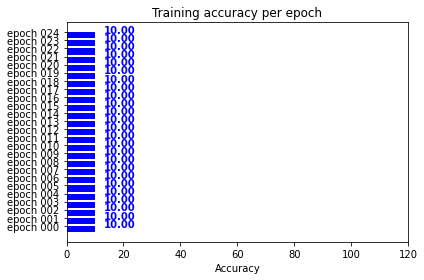


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


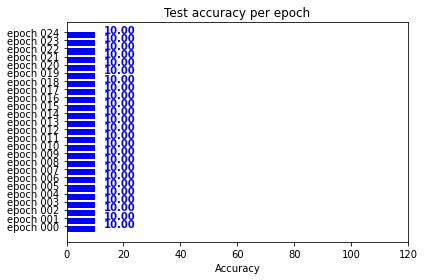


Epoch time list: [ 23.8297267   47.89294124  71.45966625  95.71346664 122.26352787
 146.66800761 170.98797154 195.29653358 219.47637248 243.96395516
 268.4016819  292.57848072 316.51459241 340.60968232 364.78986764
 388.97008419 413.38393021 437.78494716 461.89715862 486.39095926
 510.3018899  533.86501503 557.62572789 581.04819369 604.88069844]
Epoch time (Mean +/- Std): 315.86 (+/- 349.84)


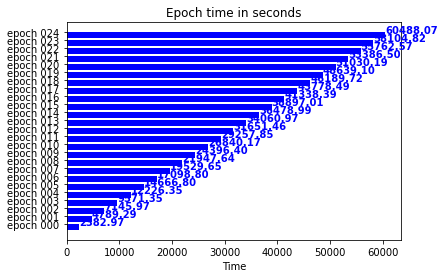

In [36]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.0001, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

## Best learning rate

* Highest test accuracy (mean)

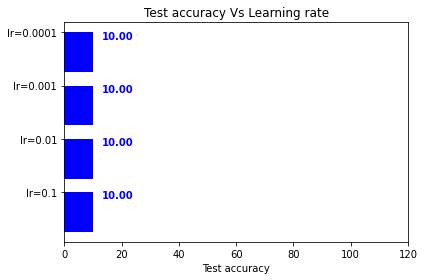

In [37]:
labels = ['lr=0.1', 'lr=0.01', 'lr=0.001', 'lr=0.0001']
plot_horizontal_bar(labels, test_accuracy_list, xlabel='Test accuracy', ylabel='', title='Test accuracy Vs Learning rate', use_xlim=True)

In [0]:
test_accuracy_list = []

## Testing different batch size

* Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=8**, shuffle=True

* Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=16**, shuffle=True

* Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=32**, shuffle=True

* Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=64**, shuffle=True

* Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=128**, shuffle=True

In [86]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=epochs, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=3072, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


### Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=8**, shuffle=True

Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 1154.49 seconds


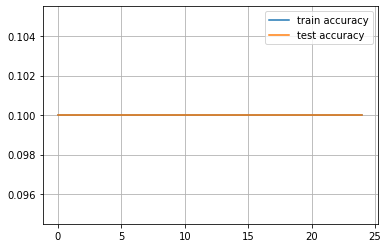

Total time: 1154.6405699253082 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


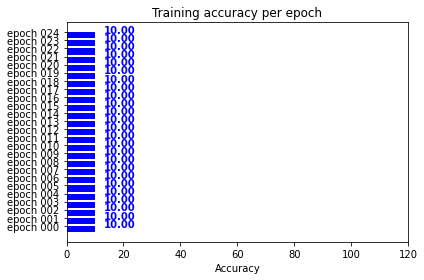


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


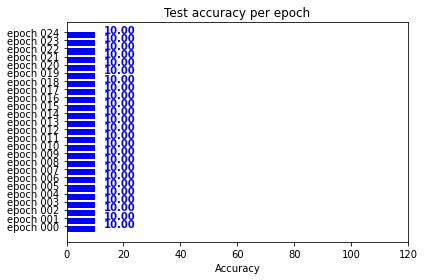


Epoch time list: [  48.34768105   94.63115501  141.43452764  188.23047376  235.00926399
  281.07455039  327.94285178  374.58387542  420.38451767  467.23625159
  512.32983398  558.92410707  603.46721148  651.67414618  696.03545237
  742.35902643  790.21098185  839.11398888  883.53427124  931.75278878
  977.7356987  1022.07584381 1065.99621415 1110.1418221  1154.4868288 ]
Epoch time (Mean +/- Std): 604.75 (+/- 666.89)


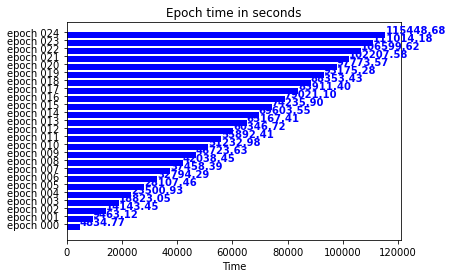

In [87]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=epochs, dense_output_units=dense_output_units, batchsize=8, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=16**, shuffle=True

Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 797.90 seconds


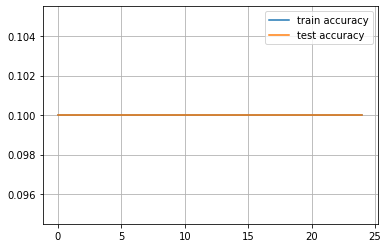

Total time: 798.050637960434 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


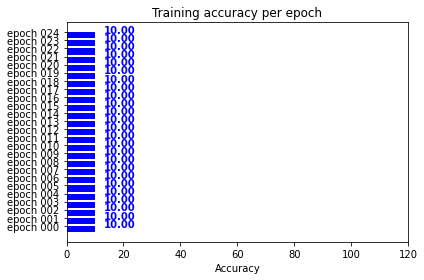


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


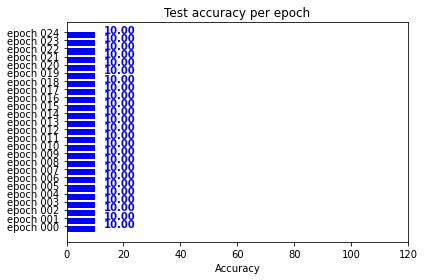


Epoch time list: [ 30.79096174  60.74500394  91.32884121 122.67299104 153.49188924
 184.66478181 216.0826664  247.30098796 278.35509968 308.90957308
 342.20639157 375.81150651 408.44719887 441.84705186 475.05714917
 507.78396058 540.59208822 575.25460339 608.33252215 640.78073359
 672.76519156 704.0007689  735.49636769 766.61116099 797.89677548]
Epoch time (Mean +/- Std): 411.49 (+/- 465.55)


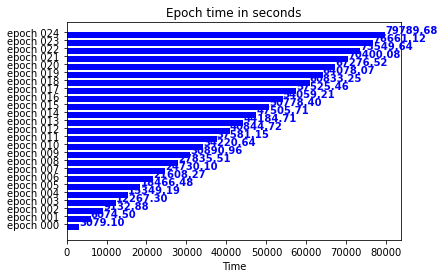

In [88]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=epochs, dense_output_units=dense_output_units, batchsize=16, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=32**, shuffle=True

Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 614.06 seconds


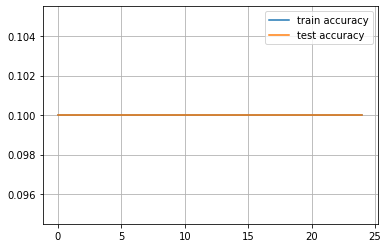

Total time: 614.2346198558807 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


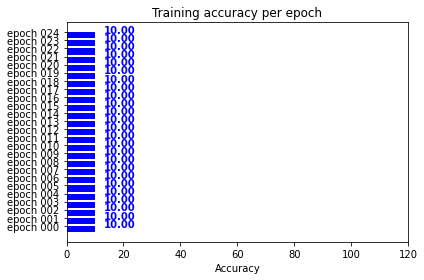


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


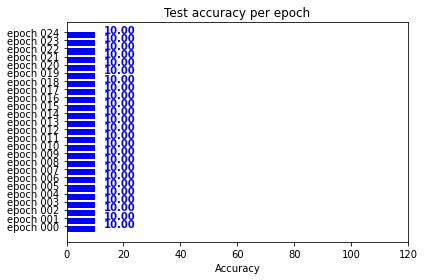


Epoch time list: [ 24.31164312  48.4913857   73.30567551  97.79361391 123.43325043
 147.19846463 171.48555803 196.27800202 220.65608525 244.531322
 268.98835707 293.34144282 318.62942362 342.48498845 367.32535672
 392.2998569  417.52932405 441.87509847 466.94901752 491.17726851
 516.08091021 540.60373616 564.84177113 590.46330643 614.05923104]
Epoch time (Mean +/- Std): 318.97 (+/- 354.63)


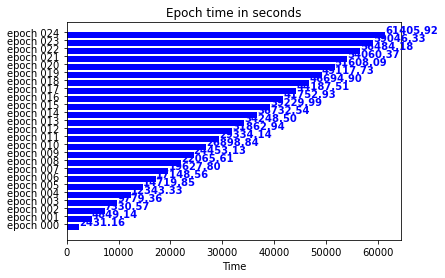

In [89]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=64**, shuffle=True

Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 507.51 seconds


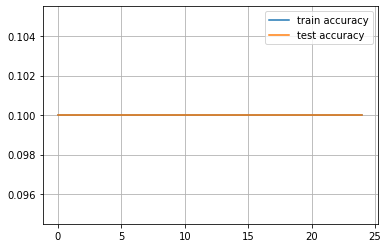

Total time: 507.6639349460602 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


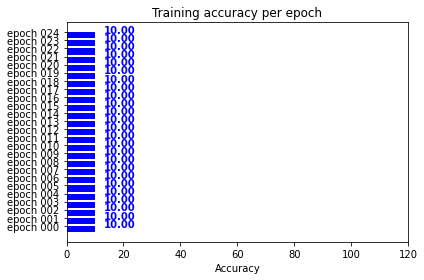


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


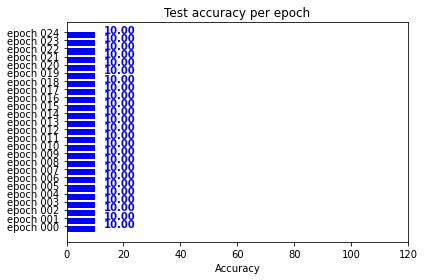


Epoch time list: [ 20.20021272  40.3509984   60.63944578  80.26129866 100.37085795
 120.83333516 141.1561296  161.49870467 181.05009127 201.19732285
 221.74302173 242.301404   262.56390047 282.75887084 302.99380589
 323.66273284 344.25800037 364.34782791 384.79925442 405.9088726
 426.705549   446.74884725 466.90307355 487.01515412 507.51192951]
Epoch time (Mean +/- Std): 263.11 (+/- 293.19)


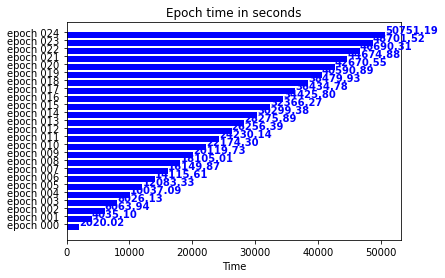

In [90]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=epochs, dense_output_units=dense_output_units, batchsize=64, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=128**, shuffle=True

Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 464.55 seconds


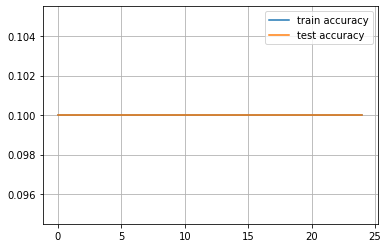

Total time: 464.7068564891815 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


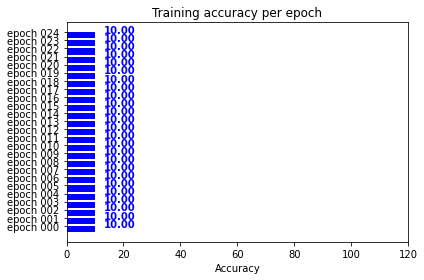


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


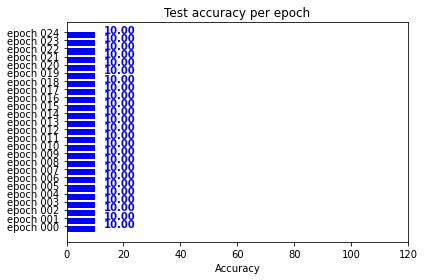


Epoch time list: [ 18.49986696  36.5662334   55.04083061  73.70944691  92.26643014
 111.15567327 129.87694311 148.47711587 167.20430088 186.19311881
 204.95031309 223.38214469 242.00704455 260.28833771 278.97439885
 297.5833745  315.94582438 334.41022944 353.10627413 371.84736466
 390.44786191 408.81491899 427.33736444 445.89801908 464.54814887]
Epoch time (Mean +/- Std): 241.54 (+/- 268.34)


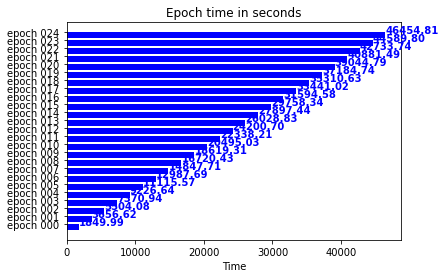

In [91]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=epochs, dense_output_units=dense_output_units, batchsize=128, shuffle=True)

## Best batch size

* Highest test accuracy (mean)

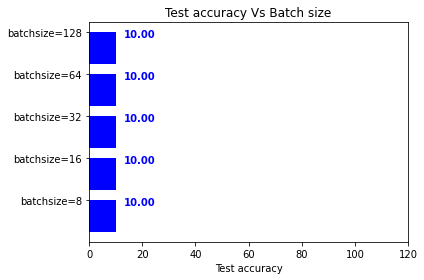

In [92]:
labels = ['batchsize=8', 'batchsize=16', 'batchsize=32', 'batchsize=64', 'batchsize=128']
plot_horizontal_bar(labels, test_accuracy_list, xlabel='Test accuracy', ylabel='', title='Test accuracy Vs Batch size', use_xlim=True)

In [0]:
test_accuracy_list = []

## Testing different activation functions

* Using 3 dense layers with learning_rate=0.001, **activation function = RELU**, minibatches with batchsize=32, shuffle=True

* Using 3 dense layers with learning_rate=0.001, **activation function = LEAKY_RELU**, minibatches with batchsize=32, shuffle=True

* Using 3 dense layers with learning_rate=0.001, **activation function = TANH**, minibatches with batchsize=32, shuffle=True

* Using 3 dense layers with learning_rate=0.001, **activation function = SIGMOID**, minibatches with batchsize=32, shuffle=True

### Using 3 dense layers with learning_rate=0.001, **activation function = RELU**, minibatches with batchsize=32, shuffle=True

In [94]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=epochs, dense_output_units=dense_output_units, activation_function=ActivationFunction.RELU, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=3072, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 603.98 seconds


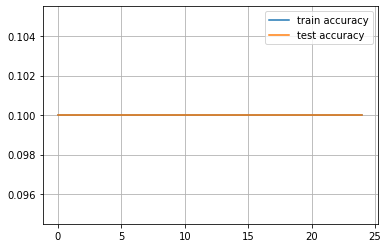

Total time: 604.1366245746613 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


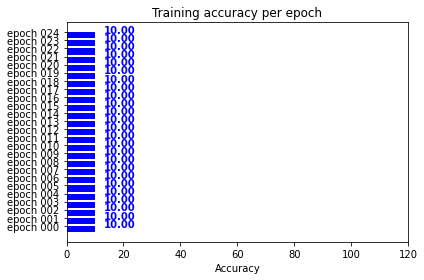


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


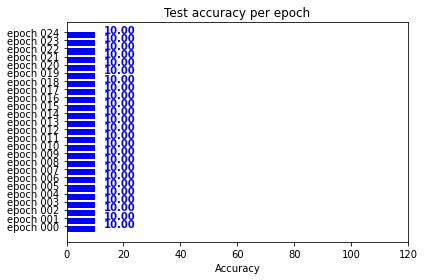


Epoch time list: [ 24.55540586  48.33826661  73.03839493  97.70392179 122.56855226
 146.48371506 170.77096915 194.53256893 218.88507962 242.14677763
 266.19724488 290.41436601 315.00737834 338.29341364 362.24255037
 386.81142163 411.19846225 434.80119205 459.05567336 483.34824753
 507.8252883  531.16724348 555.36125255 579.73600006 603.97686148]
Epoch time (Mean +/- Std): 314.58 (+/- 347.66)


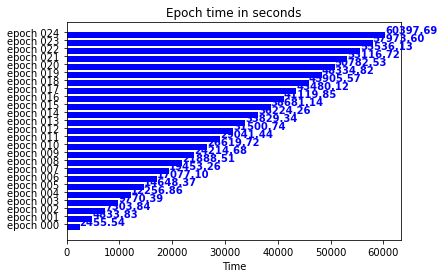

In [95]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, **activation function = LEAKY_RELU**, minibatches with batchsize=32, shuffle=True

In [96]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=epochs, dense_output_units=dense_output_units, activation_function=ActivationFunction.LEAKY_RELU, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=3072, output_units=100, learning_rate=0.1)
		LEAKY_RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		LEAKY_RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		LEAKY_RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 626.71 seconds


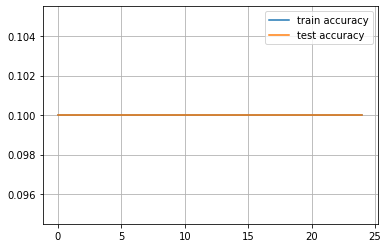

Total time: 626.8916318416595 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


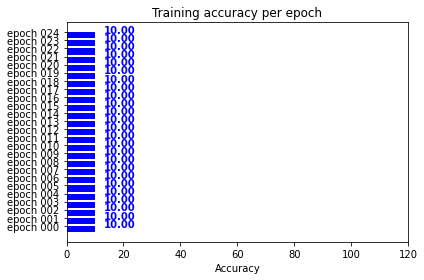


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


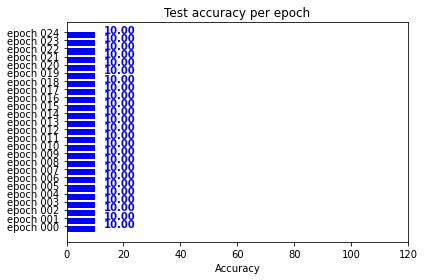


Epoch time list: [ 23.76536322  48.8060329   73.35311699  98.28997302 121.7923677
 146.30631733 171.10120201 195.94287491 219.59181714 244.13278031
 269.37899876 295.49540949 321.27783966 347.28806663 373.66619778
 399.62032247 425.09551048 450.97679067 476.72343707 502.87009144
 528.37054014 552.85935497 577.72761989 602.81904149 626.71356082]
Epoch time (Mean +/- Std): 323.76 (+/- 364.69)


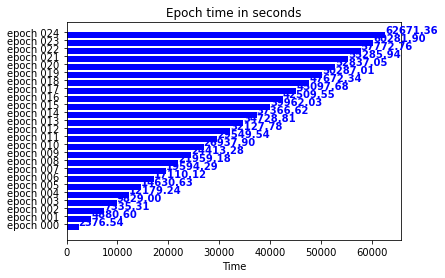

In [97]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, **activation function = TANH**, minibatches with batchsize=32, shuffle=True

In [98]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=epochs, dense_output_units=dense_output_units, activation_function=ActivationFunction.TANH, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=3072, output_units=100, learning_rate=0.1)
		TANH()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		TANH()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		TANH()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 631.23 seconds


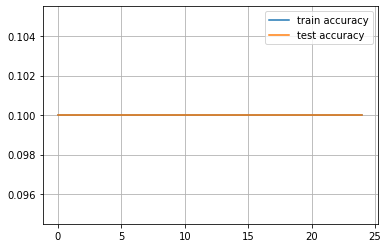

Total time: 631.3887498378754 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


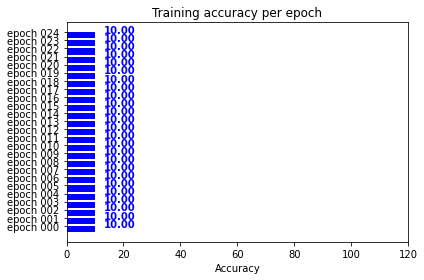


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


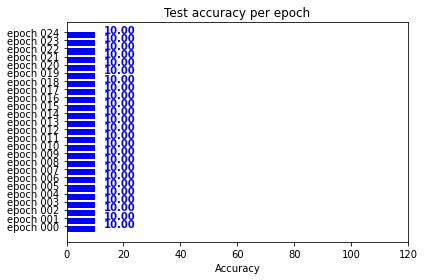


Epoch time list: [ 26.08671188  51.52434182  78.02039576 102.47894144 128.38332272
 153.91969681 179.71870852 204.06206441 229.03693414 255.33927441
 281.77395034 307.63962269 333.32360053 358.47942567 382.97037458
 407.69039202 432.6122973  457.63394856 482.95213485 507.18981957
 531.89395595 557.4551723  582.47813964 606.41065741 631.23423243]
Epoch time (Mean +/- Std): 330.81 (+/- 364.09)


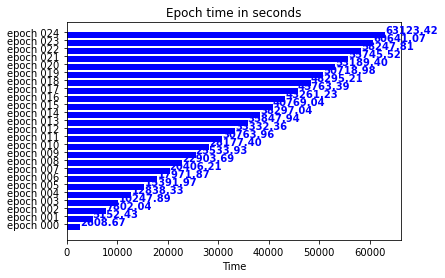

In [99]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, **activation function = SIGMOID**, minibatches with batchsize=32, shuffle=True

In [100]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=epochs, dense_output_units=dense_output_units, activation_function=ActivationFunction.SIGMOID, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=3072, output_units=100, learning_rate=0.1)
		SIGMOID()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		SIGMOID()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		SIGMOID()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 690.98 seconds


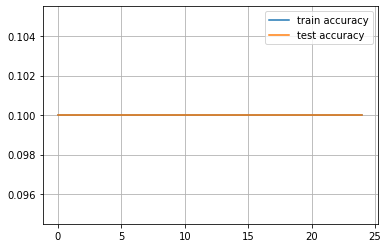

Total time: 691.1457462310791 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


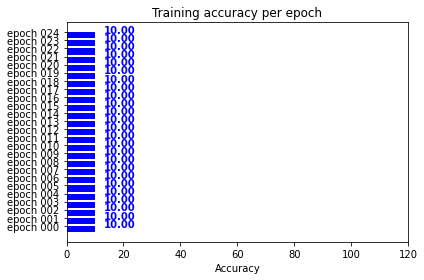


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


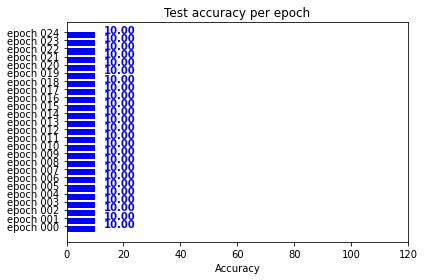


Epoch time list: [ 27.46623659  55.49371219  82.06113791 109.95574212 137.50785565
 165.51828623 192.73230624 220.41501784 248.4726491  275.68544579
 303.23846912 331.03937316 358.92325854 386.35168409 414.21512318
 442.313802   470.24575472 497.04386973 524.60096669 552.31627297
 579.58809853 607.18501401 635.21938229 663.58849812 690.98085403]
Epoch time (Mean +/- Std): 358.89 (+/- 398.73)


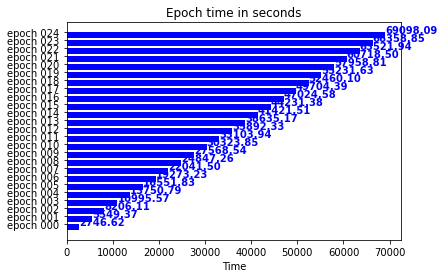

In [101]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

## Best activation functions

* Highest test accuracy (mean)

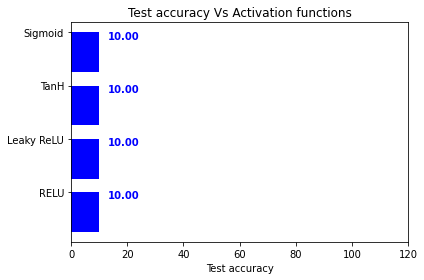

In [102]:
# ReLU layer, Leaky_ReLU, TanH(Hyperbolic tangent function), Sigmoid 
labels = ['RELU', 'Leaky ReLU', 'TanH', 'Sigmoid']
plot_horizontal_bar(labels, test_accuracy_list, xlabel='Test accuracy', ylabel='', title='Test accuracy Vs Activation functions', use_xlim=True)

## Conclusion: Best MLP model

### Best MLP model: 
**Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with batchsize=32, shuffle=True**

In [103]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=epochs, dense_output_units=dense_output_units, activation_function=ActivationFunction.RELU, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=3072, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 608.38 seconds


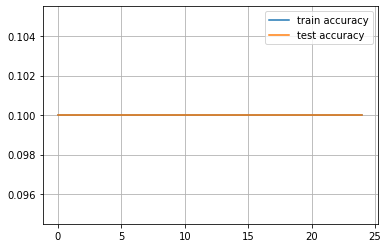

Total time: 608.5332221984863 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


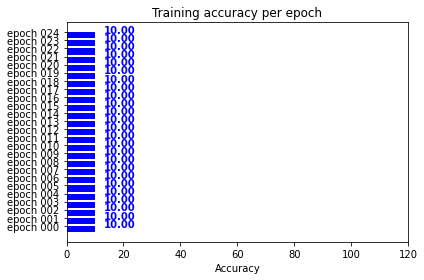


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


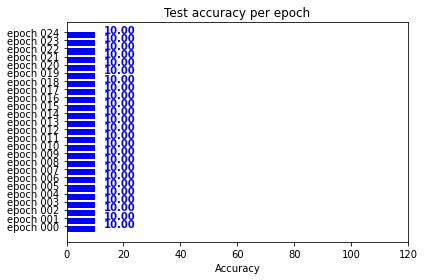


Epoch time list: [ 24.48591042  49.20953107  74.27661037  98.35148787 122.44145775
 147.08555269 171.83749318 196.15040135 220.28130484 244.65087104
 269.31802964 293.54201984 316.90689898 341.42997432 365.72198081
 390.14677429 413.54208112 437.27299619 461.44738293 486.18814421
 510.53374147 534.57225895 559.6190691  583.86187816 608.38276863]
Epoch time (Mean +/- Std): 316.85 (+/- 349.90)


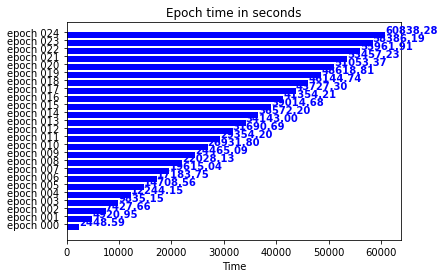

In [104]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

**Reference:** 

https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c

http://home.mit.bme.hu/~hadhazi/Oktatas/NN18/dem3/html_demo/CIFAR-10Demo.html

http://www.cs.nthu.edu.tw/~shwu/courses/ml/labs/11_NN_Regularization/11_NN_Regularization.html

https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9

https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9